In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import sys
sys.path.append("../") 
# import include.allegro_hand as allegro
import matplotlib
# matplotlib.use('Agg')
import matplotlib.ticker as mtick

%load_ext autoreload
%autoreload 2

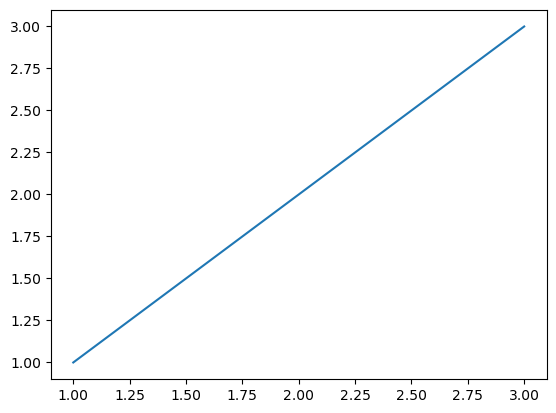

In [2]:
import matplotlib.pyplot as plt
plt.plot([1,2,3], [1,2,3])
plt.show()

### Metrics 1: palm penetration穿模次数


### metrics 2: finger penetration穿模次数穿模次数


### Metrics 3: fingertip lose contact 失去接触次数


### Metrics 4, finger manipulability index
$\omega = \sqrt{\det{JJ^T}}$
 larger manipulability index value corresponds to a configuration further away from the singularity



In [4]:
objectNames = ['finger_tip', 'apc_red_bowl', 'apc_2x2', 'bunny']
batchExperiments_all = ['00', '01', '10', '11']
# batchExperiments_all = ['01']


# hand = allegro.Robot(use_fingers=[1, 1, 1, 1], path_prefix='../', all_link_fk=False,  right_hand=False, tip_link=['link_15_tip', 'link_3_tip', 'link_7_tip', 'link_11_tip'])

# def get_manipulability_index(q: np.ndarray):
#     if len(q.shape) ==1:
#         q = q.reshape(1,-1)
#     w_all = []
#     for i in range(q.shape[0]):
#         _, jacs = hand.forward_kine(q[i, :])
#         w = []
#         for jac in jacs:
#             jac = jac[:3,:]
#             w_i = np.sqrt(np.linalg.det(jac @ jac.T))
#             w.append(w_i)
#         w_all.append(np.array(w))
    
#     return np.min(np.vstack(w_all), axis=0)



In [5]:
objectNames

['finger_tip', 'apc_red_bowl', 'apc_2x2', 'bunny']

In [6]:
i_list = {}
# i_list[objectNames[0]]  =  list(range(185, 194+1))
i_list[objectNames[0]]  =  list(range(21100, 21109 + 1 ))
i_list[objectNames[1]]  =  list(range(21100, 21109+1))
i_list[objectNames[2]]  =  list(range(600, 609+1))
i_list[objectNames[3]]  =  list(range(131, 138+1)) + [822, 823]


In [ ]:
import gc
fig_width = 85/25.4 *2  # mm to inch
# batchExperiments_all = ['00']

for obj in objectNames:
    for batch in batchExperiments_all:
        
        if batch =='11':
            trials = i_list[obj]
        else:
            trials = list(range(0,10))
            import matplotlib.ticker as mtick
        for i in trials:
            print(obj, batch, i)
            if batch =='11':
                suffix = i
            else:
                suffix = int('2' + batch + '00') + i
            path = '../records/' + obj + '_' + str(suffix) + '.npy'
            tmp = np.load(path)
            fig, ax = plt.subplots(ncols=1, figsize=(fig_width *4, fig_width *4 *4/5),clear=True)
            for j in range(2,5):
                # ax.plot(tmp[200:,i] - tmp[199:-1,i])
                ax.plot(tmp[::100,j])
            name = obj+ ' - ' + batch + ': ' + str(i)
            ax.set_title(name)            
    # ax[1].legend()

            fig.savefig( name +'.jpg',format='jpg',dpi=300,bbox_inches='tight',  pad_inches=0.0)
            # fig.clear()
            # plt.close(fig)
            plt.cla()
            plt.close()
            # del tmp
            # del fig
            # del ax
            # Clear the current axes.
            plt.cla() 
            # Clear the current figure.
            plt.clf() 
            # Closes all the figure windows.
            plt.close('all')   
            plt.close(fig)
            gc.collect()

In [ ]:
a = np.array([[1,2], [3,4.]])
np.sum(a**2, axis=1)

In [40]:
'11' =='10'

False

In [7]:
# Load data
results = {}
result_metrics = {}
penetration_threshold = 5 # 2N for detection of penetration
rate_threshold= 0.2
for obj in objectNames:
    for batch in batchExperiments_all:
        
        
        # data = []

        metrics_10 = []
        trials = list(range(0,10))
        if batch =='11':
            # trials = i_list[obj]
            pass
        else: 
            if batch=='10' and obj=='bunny':
                trials=[0,1,2,3,4,5,8,9,10,11] # 6 stuck, 7 and 8 are the same 
            if obj=='apc_red_bowl' and batch == '00':
                trials=list(range(11,21))
            if obj=='apc_red_bowl' and batch == '01':
                trials=list(range(10,20))
            
        for i in trials:
            print(obj, batch, i)
            # if batch =='11':
            #     # random_list[objectNames[0]]  =  list(range(185, 194+1))

            #     suffix = i
            # else:
                
            suffix = int('2' + batch + '00') + i
            path = '../records/' + obj + '_' + str(suffix) + '.npy'
            tmp = np.load(path)
            # order of meshes 'thumb_tip', 'index_tip', 'middle_tip', 'ring_tip', "allegro_mount", "base_link_left", 'link_' 1 to 16
            # time_now, step palm_pose, joints, contacts between meshes and the obj.
            # 1,         1,      7,        16,      6x22  (3+3, 22) (pos, force)* 22 meshes
            # 0         1,      2,         9,   ,   25, 
            # data.append(tmp)
            # compute the 4 metrics
            steps = np.int32(tmp[:,1])
            metrics = [0,0,0]
            if tmp.shape[1] == 156:  # old data without step info
                pass
                n = tmp.shape[0]/201
                n = int(n)
                steps = np.repeat(np.arange(1,202), n)
                step_add = np.ones(tmp.shape[0] - steps.shape[0]) * 201
                steps = np.concatenate([steps, step_add]).reshape(-1,1)
                tmp = np.concatenate([tmp[:,0:1], steps, tmp[:,1:]], axis=1)
                steps = np.int32(steps.flatten())
                

            for j in range(np.min(steps)+1, np.max(steps) + 1):  # for each step
                tmp_j = tmp[steps==j,:]
                F = [np.sqrt(np.sum(tmp_j[:, 28 + 6*k:31 + 6*k]**2, axis=1)) for k in [0,1,2,3,5]]# thumb_tip
                q = tmp_j[:, 9:25]
                # F = tmp_j[:,28+6:31+6] # 'index_tip'
                # F = tmp_j[:,28+6*2:31+6*2] # 'middle_tip'
                # F = tmp_j[:,28+6*3:31+6*3] # 'ring_tip'
                # F = tmp_j[:,28+6*5:31+6*5] # 'base_link_left'

                # if np.sum(F[-1] > penetration_threshold) > rate_threshold* tmp_j.shape[0]: # palm penetration, if big contact force occurs
                #     metrics[0] += 1
                metrics[0] += np.sum(F[-1] > penetration_threshold) / tmp_j.shape[0]
                # if np.sum(F[-1] > penetration_threshold) > rate_threshold* tmp_j.shape[0]: # palm penetration, if big contact force occurs
                #     metrics[0] += 1
                
                finger_tip_pen = [np.sum(F[k] > penetration_threshold)/tmp_j.shape[0] for k in [0,1,2,3]] # thumb_tip, index_tip, middle_tip, ring_tip
                metrics[1] += sum(finger_tip_pen)/4


                # if np.any([np.sum(F[k] > penetration_threshold) > rate_threshold* tmp_j.shape[0] for k in [0,1,2,3]]) : # fingertips penetration, if big contact force occurs once
                #     metrics[1] += 1
                
                lose_contact = [np.sum(F[k] == 0) == F[k].shape[0] for k in [0,1,2,3]]
                if np.any(lose_contact) : # fingertips lose contact, if zero force for this step all the time
                    metrics[2] += np.sum(lose_contact)/4
                
                # manipula_index  = get_manipulability_index(q)
                # metrics[3].append(manipula_index)
            
            metrics_10.append(metrics)
            
            
        # results[obj+batch] = data
        result_metrics[obj+batch] = metrics_10


finger_tip 00 0
finger_tip 00 1
finger_tip 00 2
finger_tip 00 3
finger_tip 00 4
finger_tip 00 5
finger_tip 00 6
finger_tip 00 7
finger_tip 00 8
finger_tip 00 9
finger_tip 01 0
finger_tip 01 1
finger_tip 01 2
finger_tip 01 3
finger_tip 01 4
finger_tip 01 5
finger_tip 01 6
finger_tip 01 7
finger_tip 01 8
finger_tip 01 9
finger_tip 10 0
finger_tip 10 1
finger_tip 10 2
finger_tip 10 3
finger_tip 10 4
finger_tip 10 5
finger_tip 10 6
finger_tip 10 7
finger_tip 10 8
finger_tip 10 9
finger_tip 11 0
finger_tip 11 1
finger_tip 11 2
finger_tip 11 3
finger_tip 11 4
finger_tip 11 5
finger_tip 11 6
finger_tip 11 7
finger_tip 11 8
finger_tip 11 9
apc_red_bowl 00 11
apc_red_bowl 00 12
apc_red_bowl 00 13
apc_red_bowl 00 14
apc_red_bowl 00 15
apc_red_bowl 00 16
apc_red_bowl 00 17
apc_red_bowl 00 18
apc_red_bowl 00 19
apc_red_bowl 00 20
apc_red_bowl 01 10
apc_red_bowl 01 11
apc_red_bowl 01 12
apc_red_bowl 01 13
apc_red_bowl 01 14
apc_red_bowl 01 15
apc_red_bowl 01 16
apc_red_bowl 01 17
apc_red_bowl 01 18

In [ ]:
# check the histogram to determine the threshold of contact force
path = '../records/' + 'apc_2x2' + '_' + str(21005) + '.npy'
tmp = np.load(path)
steps = np.int32(tmp[:,1])

F_all = []
for j in range(np.min(steps), np.max(steps) + 1):  # for each step
    tmp_j = tmp[steps==j,:]
    F = [np.sqrt(np.sum(tmp_j[:, 28 + 6*k:31 + 6*k]**2, axis=1)) for k in [0,1,2,3,5]]# thumb_tip
    F_all.append(F[3])
F_all = np.hstack(F_all)
F_all = F_all[F_all>0]
_ = plt.hist(F_all, bins=np.linspace(np.min(F_all), np.max(F_all), 100))
print('mean',np.mean(F_all), ' std', np.std(F_all))
print(np.mean(F_all) + 3* np.std(F_all))

In [ ]:
tmp = result_metrics[objectNames[0] + '11'][7]
# len(tmp)
# np.vstack(tmp[3])

In [ ]:
len(result_metrics[obj + batch])

In [8]:
metric = {}
metric_data = {}
# manipu = {}
for obj in objectNames:
    # metric = [{}, {}, {}]
    # manipu = [{}] *4
    for j in range(0,3):
        for batch in batchExperiments_all:
            tmp= [] 
            for i in range(len(result_metrics[obj + batch])): # trials
                tmp.append(result_metrics[obj + batch][i][j] / 200)
            metric_data[obj + '_'+ batch +'_' + str(j)] = np.array(tmp)
            metric[obj + batch + str(j)] = [np.mean(tmp), np.std(tmp)]
            if len(tmp) !=10:
                print(len(tmp))
    # for batch in batchExperiments_all:
    #     manipu_list = []
    #     for i in range(len(result_metrics[obj + batch])):
    #         tmp = result_metrics[obj + batch][i][3]
    #         # len(tmp)
    #         tmp = np.vstack(tmp)  # (200,4)
    #         manipu_list.append(tmp)
    #     manipu_list = np.vstack(manipu_list) # (200*10, 4)

    #     manipu[obj + batch] = [np.mean(manipu_list, axis=0), np.std(manipu_list, axis=0)]
        

In [32]:
from scipy.io import savemat
from numpy import *


# print data
savemat('metric_data.mat', metric_data, oned_as='row')

In [33]:
savemat('metric_data_mean_std.mat', metric, oned_as='row')

In [ ]:
import matplotlib.ticker as mtick
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm



In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
result_metrics[obj + batch][0]

In [ ]:
result_metrics[obj + batch][i]

In [ ]:
result_metrics[obj + batch][i][3]

TypeError: list indices must be integers or slices, not list

/home/xiao/miniconda3/envs/stock/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/xiao/miniconda3/envs/stock/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/xiao/miniconda3/envs/stock/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


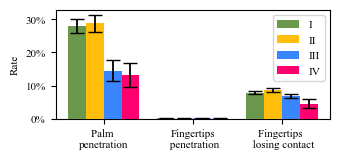

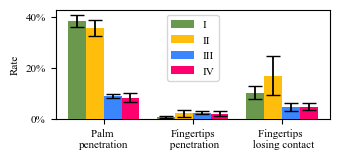

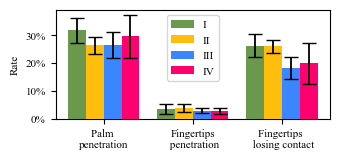

In [9]:


fig_width = 90/25.4   # mm to inch
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "8"

x = np.arange(6)  # the label locations
width = 0.6  # the width of the bars
interval = 3
labels = ['Palm \npenetration', 'Fingertips\n penetration', 'Fingertips \n losing contact']
colors = np.array([[213,94,0],[204,121,167], [0,114,178], [0,158,115]])/255.
batchExperiments_all = ['00','01', '10', '11']
batch2num = {'00':'I', '01':'II', '10':'III', '11':'IV'}


for obj in [objectNames[i] for i in [0,2,3]]:
    
    fig, ax = plt.subplots(ncols=1, figsize=(fig_width, fig_width *2/5))
    first = True
    color_bar = [2, 5,'k']
    
    for i in range(3): # 3 metrics
        for j, batch in enumerate(batchExperiments_all):
            if first:
                rects1 = ax.bar( width/2 + i * interval + j* width, metric[obj + batch + str(i)][0], width, label=batch2num[batch],color=colors[j], zorder=10)
            else:
                rects1 = ax.bar( width/2 + i * interval + j* width, metric[obj + batch + str(i)][0], width,color=colors[j], zorder=10)
            ax.errorbar( width/2 + i * interval + j* width, metric[obj + batch + str(i)][0], yerr=metric[obj + batch + str(i)][1], linewidth=color_bar[0], capsize=color_bar[1],ecolor=color_bar[2], zorder=20, elinewidth=1.3)
        first = False
    # first = True
    # for i in range(4):
    #     for j, batch in enumerate(batchExperiments_all):
    #         if first:
    #             rects1 = ax[1].bar( width/2 + i * interval + j* width, manipu[obj + batch][0][i], width, label=batch, color=colors[j], zorder=10)
    #         else:
    #             rects1 = ax[1].bar( width/2 + i * interval + j* width, manipu[obj + batch][0][i], width,color=colors[j], zorder=10)

    #         ax[1].errorbar( width/2 + i * interval + j* width, manipu[obj + batch][0][i], yerr=manipu[obj + batch][1][i], linewidth=color_bar[0], capsize=color_bar[1],ecolor=color_bar[2], zorder=20)



    ax.set_xticks(np.arange(3) * interval + width*2)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Rate')
    ax.legend()
    if obj=='finger_tip':
        obj = 'convex object'
    elif obj=='apc_2x2':
        obj = 'bottle'
    else:
        pass
    # ax.set_title('Exploration of the ' + obj)
    ax.set_ylim((0, None))

    # ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


    # ax[1].set_xticks(np.arange(4) * interval + width)
    # ax[1].set_xticklabels(['Thumb', 'Index', 'Middle', 'Ring'])
    # ax[1].ticklabel_format(axis='y', style='sci',scilimits=(0,0))
    # ax[1].set_title('Manipulibility index - ' + obj)
    # # ax[1].legend()


    # fig.savefig( obj +'.jpg',format='jpg',ppi=1200,bbox_inches='tight',  pad_inches=0.0)
    fig.savefig( obj +'.pdf',format='pdf',bbox_inches='tight',  pad_inches=0.0)


/home/xiao/miniconda3/envs/stock/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/xiao/miniconda3/envs/stock/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator


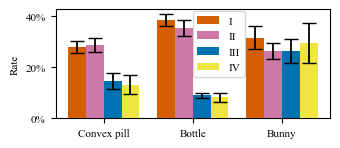

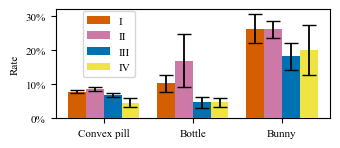

In [37]:


fig_width = 90/25.4   # mm to inch
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "8"

x = np.arange(6)  # the label locations
width = 0.6  # the width of the bars
interval = 3
labels = ['Palm \npenetration', 'Fingertips\n penetration', 'Fingertips \n losing contact']
labels = ['Convex pill', 'Bottle', 'Bunny']
colors = np.array([[213,94,0],[204,121,167], [0,114,178], [240,228,66]])/255.
batchExperiments_all = ['00','01', '10', '11']
batch2num = {'00':'I', '01':'II', '10':'III', '11':'IV'}
y_labels = ['Unwanted palm contact', '', 'Fingertips losing contact']
for m in [0,2]:
    fig, ax = plt.subplots(ncols=1, figsize=(fig_width, fig_width *2/5))
    first = True
    color_bar = [2, 5,'k']
    for i, obj in enumerate([objectNames[i] for i in [0,2,3]]):        
        for j, batch in enumerate(batchExperiments_all):
            if first:
                rects1 = ax.bar( width/2 + i * interval + j* width, metric[obj + batch + str(m)][0], width, label=batch2num[batch],color=colors[j], zorder=10)
                
            else:
                rects1 = ax.bar( width/2 + i * interval + j* width, metric[obj + batch + str(m)][0], width,color=colors[j], zorder=10)
            ax.errorbar( width/2 + i * interval + j* width, metric[obj + batch + str(m)][0], yerr=metric[obj + batch + str(m)][1], linewidth=color_bar[0], capsize=color_bar[1],ecolor=color_bar[2], zorder=20, elinewidth=1.3)
        first=False
# for obj in [objectNames[i] for i in [0,2,3]]:
    
    
    
#     for i in range(3): # 3 metrics
#         for j, batch in enumerate(batchExperiments_all):
#             if first:
#                 rects1 = ax.bar( width/2 + i * interval + j* width, metric[obj + batch + str(i)][0], width, label=batch2num[batch],color=colors[j], zorder=10)
#             else:
#                 rects1 = ax.bar( width/2 + i * interval + j* width, metric[obj + batch + str(i)][0], width,color=colors[j], zorder=10)
#             ax.errorbar( width/2 + i * interval + j* width, metric[obj + batch + str(i)][0], yerr=metric[obj + batch + str(i)][1], linewidth=color_bar[0], capsize=color_bar[1],ecolor=color_bar[2], zorder=20, elinewidth=1.3)
#         first = False
    # first = True
    # for i in range(4):
    #     for j, batch in enumerate(batchExperiments_all):
    #         if first:
    #             rects1 = ax[1].bar( width/2 + i * interval + j* width, manipu[obj + batch][0][i], width, label=batch, color=colors[j], zorder=10)
    #         else:
    #             rects1 = ax[1].bar( width/2 + i * interval + j* width, manipu[obj + batch][0][i], width,color=colors[j], zorder=10)

    #         ax[1].errorbar( width/2 + i * interval + j* width, manipu[obj + batch][0][i], yerr=manipu[obj + batch][1][i], linewidth=color_bar[0], capsize=color_bar[1],ecolor=color_bar[2], zorder=20)



    ax.set_xticks(np.arange(3) * interval + width*2)
    ax.set_xticklabels(labels)
    ax.set_ylabel(y_labels[m])
    ax.set_ylabel('Rate')
    ax.legend()
    if obj=='finger_tip':
        obj = 'convex object'
    elif obj=='apc_2x2':
        obj = 'bottle'
    else:
        pass
    # ax.set_title('Exploration of the ' + obj)
    ax.set_ylim((0, None))

    # ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


    # ax[1].set_xticks(np.arange(4) * interval + width)
    # ax[1].set_xticklabels(['Thumb', 'Index', 'Middle', 'Ring'])
    # ax[1].ticklabel_format(axis='y', style='sci',scilimits=(0,0))
    # ax[1].set_title('Manipulibility index - ' + obj)
    # # ax[1].legend()
    if m ==0:
        plt.legend(loc=(0.5,0.38))
    else:
        plt.legend(loc=(0.1,0.38))

    # fig.savefig( obj +'.jpg',format='jpg',ppi=1200,bbox_inches='tight',  pad_inches=0.0)
    fig.savefig( y_labels[m] +'.pdf',format='pdf',bbox_inches='tight',  pad_inches=0.0)


In [20]:
rcParams["legend.loc"]

NameError: name 'rcParams' is not defined

In [ ]:
metric[obj + batch + str(i)][0]

In [ ]:
labels = ['s'+str(i) for i in range(1,11)]
labels = reversed([
                    [350,175,90],
                    [300,150,75],
                    [250, 125, 65],
                    [200,100,50],
                    [180,90,45],
                    [150,75,40],
                    [130,65,35],
                    [100,50,25],
                    [80,40,20],
                    [50,25,15]
                    ])
x = np.arange(6)  # the label locations
width = 0.6  # the width of the bars
fig, ax = plt.subplots(figsize=(20, 6))
interval = 6
train_color = np.array([255, 190,ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

first = True
for i in reversed(range(10)):ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

    else:
        rects1 = ax.bar( width/2 + (9-i) * interval, data1[i, train[0]], width, color=train_color,zorder=10)
        rects2 = ax.bar(width/2*3 +  (9-i) * interval, data1[i, test[0]], width,  color=test_color,zorder=10)
    ax.errorbar(width/2 + (9-i) * interval, data1[i, train[0]], yerr=data1[i, train[0]+1],linewidth=color_bar[0], capsize=color_bar[1],ecolor=color_bar[2],zorder=20)
    ax.errorbar(width/2*3 +  (9-i) * interval, data1[i, test[0]], yerr=data1[i, test[0]+1],linewidth=color_bar[0], capsize=color_bar[1],ecolor=color_bar[2],zorder=20)
    rects1 = ax.bar( width/2 *6 + (9-i) * interval, data1[i+10, train[0]], width, color=train_color,zorder=10)
    rects2 = ax.bar(width/2 *8 +  (9-i) * interval, data1[i+10, test[0]], width, color=test_color,zorder=10)
    ax.errorbar(width/2 *6 + (9-i) * interval, data1[i+10, train[0]], yerr= data1[i+10, train[0]+1],linewidth=color_bar[0], capsize=color_bar[1],ecolor=color_bar[2],zorder=20)
    ax.errorbar(width/2 *8 +  (9-i) * interval, data1[i+10, test[0]], yerr= data1[i+10, test[0]+1],linewidth=color_bar[0], capsize=color_bar[1],ecolor=color_bar[2],zorder=20)
    rects1 = ax.bar( width/2 *11 + (9-i) * interval, data1[i+20, train[0]], width, color=train_color,zorder=10)
    rects2 = ax.bar(width/2 *13 +  (9-i) * interval, data1[i+20, test[0]], width,  color=test_color,zorder=10)
    ax.errorbar( width/2 *11 + (9-i) * interval, data1[i+20, train[0]], yerr= data1[i+20, train[0]+1],linewidth=color_bar[0], capsize=color_bar[1],ecolor=color_bar[2],zorder=20)
    ax.errorbar( width/2 *13 +  (9-i) * interval, data1[i+20, test[0]], yerr= data1[i+20, test[0]+1],linewidth=color_bar[0], capsize=color_bar[1],ecolor=color_bar[2],zorder=20)
ax.grid(zorder=0)
ax.set_ylim((0.8,1))
ax.set_xticks(np.arange(10) * interval + interval/2 - width/2*3)
ax.set_xticklabels(labels)
ax.legend()
ax.set_xlabel('NN structure')
ax.set_ylabel('Collision accuracy')
fig.savefig('figures/CV_different_input_acc.png',format='png',bbox_inches='tight',  pad_inches=0.0,dpi=300)

In [ ]:

# poses, _ = hand_ik.forward_kine(qh)

In [ ]:
results['finger_tip00'][0]